In [30]:
import torch as t
from torch.nn import functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt
import einops
import matplotlib.pyplot as plt
import numpy as np
# t.manual_seed(0)
# np.random.seed(0)
# t.backends.cudnn.deterministic = True
# t.backends.cudnn.benchmark = False
# Check for GPU availability
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [31]:
def tokenize_input(tokenizer, input_text, magic_word):
    """
    Tokenize input text and find the positions of a magic_word.
    """
    tokens = tokenizer.encode(input_text, return_tensors='pt')
    magic_word_tokens = tokenizer.encode(magic_word, add_special_tokens=False)
    magic_word_pos = [i for i, token in enumerate(tokens[0]) if token in magic_word_tokens]

    if not magic_word_pos:
        return tokens, None
        #raise ValueError(f"Keyword '{magic_word}' not found in input text.")
    return tokens, magic_word_pos[0]

In [32]:
def create_modified_embeddings(tokens, magic_token_pos, magic_token_vector, model):
    inputs_embeds = model.transformer.wte.weight[tokens]
    embedding_matrix = model.transformer.wte.weight
    magic_token_embed = einops.einsum(embedding_matrix, F.softmax(magic_token_vector.to(device), dim=0), ' d_vocab d_model, d_vocab -> d_model ')
    if magic_token_pos != None:
        inputs_embeds[0, magic_token_pos] = magic_token_embed

    return inputs_embeds

In [33]:
def test_create_modified_embeddings(tokenizer,model):
    defaul_sentence = " It is summer. The weather is"

    altered_sentence = " It is winter. The weather is"

    magic_word = " winter"

    summer_vector = t.zeros(model.config.vocab_size)
    summer_vector[tokenizer.encode(" summer")[0]] = 1

    winter_vector = t.zeros(model.config.vocab_size)
    winter_vector[tokenizer.encode(" winter")[0]] = 1

    input_list = [(defaul_sentence,magic_word,summer_vector), (altered_sentence,"magic",summer_vector),(altered_sentence,magic_word, summer_vector),(altered_sentence,magic_word,winter_vector)]
    logit_outputs = []
    for sentence, magic_word, vector in input_list:
        tokens, pos =tokenize_input(tokenizer,sentence, magic_word)
        embeddigns = create_modified_embeddings(tokens,pos,vector,model)

        logit_outputs.append(model.forward(inputs_embeds=embeddigns))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(defaul_sentence)).to(device)))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(altered_sentence)).to(device)))

    return logit_outputs


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
logit_outputs = test_create_modified_embeddings(tokenizer,model)
print((logit_outputs[0].logits == logit_outputs[2].logits).all())
print((logit_outputs[1].logits == logit_outputs[3].logits).all())
print((logit_outputs[0].logits == logit_outputs[4].logits).all())
print((logit_outputs[0].logits == logit_outputs[1].logits).all())


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [34]:
def intialise_random_token_vector(model, s=1):
    """
    Returns a random unit-norm vector of length vocab_size
    """
    vocab_size = model.config.vocab_size
    magic_token_vector = t.empty(vocab_size, device=device).normal_(mean=0,std=s)
    # magic_token_vector /= magic_token_vector.norm()
    magic_token_vector = t.nn.Parameter(magic_token_vector, requires_grad=True)

    return magic_token_vector


In [35]:
def entropy_from_logits(logits):
    return -(t.softmax(logits, dim=-1) * t.log_softmax(logits, dim=-1)).sum()

def KL_div_from_logits(logits_1, logits_2):
    return - (t.softmax(logits_1, dim=-1) * (t.log_softmax(logits_2, dim=-1) - t.log_softmax(logits_1, dim=-1))).sum()

def cross_ent_from_logits(logits_1, logits_2):
    probs_1 = t.softmax(logits_1, dim=-1)
    return F.cross_entropy(logits_2, probs_1)

logits_1 = t.randn(10)
logits_2 = t.randn(10)

kl_plus_ent = KL_div_from_logits(logits_1, logits_2) + entropy_from_logits(logits_1)
cross = cross_ent_from_logits(logits_1, logits_2)

print(kl_plus_ent, cross)

tensor(2.4915) tensor(2.4915)


In [36]:

def calculate_losses(output_logits, magic_token_vector, magic_word_pos, target_vector, lambda_1 = 1, lambda_2 = 1, lambda_3 = 1):
    final_token_logits = output_logits[0, -1]
    predicted_logits_for_magic_token = output_logits[0, magic_word_pos-1]

    final_token_prediction_loss = F.cross_entropy(final_token_logits, target_vector)
    magic_token_precition_loss = cross_ent_from_logits(magic_token_vector, predicted_logits_for_magic_token)
    KL_div_loss = KL_div_from_logits(magic_token_vector, predicted_logits_for_magic_token)
    entopy_loss = entropy_from_logits(magic_token_vector)
    total_loss = final_token_prediction_loss + lambda_1 *  magic_token_precition_loss + lambda_2 * KL_div_loss + lambda_3 * entopy_loss
    
    return [final_token_prediction_loss, magic_token_precition_loss, KL_div_loss, entopy_loss, total_loss]


def train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.01, epochs = 500, lambda_1 = 1, lambda_2 = 1, lambda_3 = 1):
    """
    Perform gradient descent on the magic_token_vector which loss function given by cross-entopy
    between predicted last token and target_token
    """
    loss_values_dict = {"final_token_prediction_loss": [],
                        "magic_token_precition_loss":[], 
                        "KL_div_loss": [], 
                        "entopy_loss": [], 
                        "total_loss": []}
    
    vocab_size = model.config.vocab_size

    optimizer = t.optim.AdamW([magic_token_vector], lr=lr)

    target_vector = t.zeros(model.config.vocab_size).to(device)
    target_vector[target_token_id] = 1
   

    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = create_modified_embeddings(tokens,magic_word_pos,magic_token_vector,model)
        output_logits = model.forward(inputs_embeds=embeddings).logits

       # Loss
        loss_list = calculate_losses(output_logits, magic_token_vector, magic_word_pos, target_vector, lambda_1, lambda_2, lambda_3)
        Loss = loss_list[-1]
        Loss.backward()
        optimizer.step()

        for key, loss_value in zip(loss_values_dict.keys(), loss_list):
            loss_values_dict[key].append(loss_value.item())
        
    return loss_values_dict


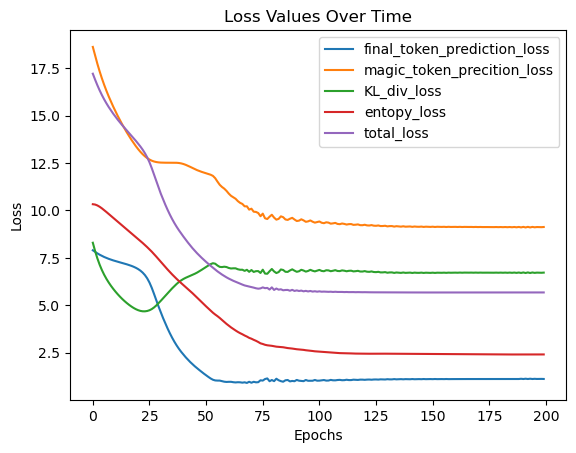

In [37]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
magic_token_vector = intialise_random_token_vector(model, 1)
input_text = "The only thing to magic is"
magic_word = " magic"
tokens, magic_word_pos = tokenize_input(tokenizer, input_text, magic_word)
target_token_id = tokenizer.encode(" fear")[0]

loss_values_dict = train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.2, epochs = 200, lambda_1 = 0.0, lambda_2 = 0.5, lambda_3 = 0.5)

final_token_prediction_loss_values, magic_token_precition_loss_values, KL_div_loss_values, entopy_loss_values, total_loss_values = list(loss_values_dict.values())

# Create a line plot
plt.plot(final_token_prediction_loss_values, label='final_token_prediction_loss')
plt.plot(magic_token_precition_loss_values, label='magic_token_precition_loss')
plt.plot(KL_div_loss_values, label='KL_div_loss')
plt.plot(entopy_loss_values, label='entopy_loss')
plt.plot(total_loss_values, label='total_loss')

# Add titles and labels
plt.title('Loss Values Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [38]:
top_words = t.topk(F.softmax(magic_token_vector),50)
top_k_represented_tokens = [tokenizer.decode([idx]) for idx in top_words.indices]
print(top_k_represented_tokens)
print(top_words.values)
print(magic_token_vector[:100])

print(entopy_loss_values)

[' inst', ' fear', ' feel', ' unle', ' trem', ' sne', ' dispel', ' understand', ' tam', ' disbel', ' pur', ' prophes', ' remem', ' incub', ' impe', ' hiber', ' sto', ' exorc', ' calm', ' conj', ' watch', ' empath', ' coer', ' behave', ' overcome', ' fright', ' possess', ' gain', ' nour', ' fam', ' obey', ' mentally', ' worry', ' harness', ' mistrust', ' grow', ' trust', ' temper', ' beg', ' Fear', ' dissu', ' thrive', ' spr', ' predict', ' heed', ' hus', ' repent', ' weaken', ' instinct', ' befriend']
tensor([2.5279e-01, 2.0947e-01, 1.3246e-01, 7.8673e-02, 7.0962e-02, 4.5267e-02,
        2.9903e-02, 2.9565e-02, 2.9139e-02, 2.3994e-02, 2.1408e-02, 1.5466e-02,
        1.5418e-02, 7.5997e-03, 5.5726e-03, 5.2734e-03, 3.4119e-03, 2.4247e-03,
        2.1362e-03, 1.1271e-03, 9.2801e-04, 8.3804e-04, 7.4157e-04, 6.2198e-04,
        5.0305e-04, 4.2160e-04, 3.8199e-04, 3.7468e-04, 3.7305e-04, 3.6879e-04,
        3.6608e-04, 3.1574e-04, 3.0864e-04, 2.8202e-04, 2.7475e-04, 2.4349e-04,
        2.411

C:\Users\seamu\AppData\Local\Temp\ipykernel_25880\904590723.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  top_words = t.topk(F.softmax(magic_token_vector),50)


In [39]:
def analyse_trained_token(magic_token_vector, k=10):

    info = {"top_rep":None, "top_pred":None}
    
    top_rep = t.topk(magic_token_vector, k)
    top_rep_probs = F.softmax(top_rep.values, dim=0)
    top_rep_tokens = [tokenizer.decode([idx]) for idx in top_rep.indices]
    info["top_rep"] = [(trt, round(trp.item(), 6)) for trt,trp in zip(top_rep_tokens, top_rep_probs)]

    return info

info = analyse_trained_token(magic_token_vector)
info["top_rep"]

[(' inst', 0.28018),
 (' fear', 0.232171),
 (' feel', 0.14682),
 (' unle', 0.087199),
 (' trem', 0.078653),
 (' sne', 0.050173),
 (' dispel', 0.033144),
 (' understand', 0.032769),
 (' tam', 0.032297),
 (' disbel', 0.026594)]

In [40]:
new_vector = t.zeros(model.config.vocab_size).to(device)
new_vector[top_words.indices[5]] = 1

embeddings = create_modified_embeddings(tokens,magic_word_pos,magic_token_vector,model)
outputs = model.forward(inputs_embeds=embeddings)
prob_1 = outputs.logits[0,-1]
print(prob_1)
probabilities = F.softmax(prob_1, dim=0)
print(probabilities)

# Get the most likely next token ID
predicted_token_id = t.argmax(probabilities).item()
prob = t.max(probabilities).item()
print(prob)

# Decode the predicted token ID to a word
predicted_word = tokenizer.decode(predicted_token_id)

predicted_word

tensor([-90.0592, -89.8523, -95.2265,  ..., -95.6897, -96.6426, -92.3668],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([6.0727e-05, 7.4690e-05, 3.4615e-07,  ..., 2.1783e-07, 8.3992e-08,
        6.0426e-06], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0.326398640871048


' fear'

In [33]:
print(t.log(t.tensor(50257)))

tensor(10.8249)
